Michael Sikora <sikoraaudio@gmail.com>

This notebook was used to develop and test a noise suppression algorithm that could be used with the Teensy Audio Library.

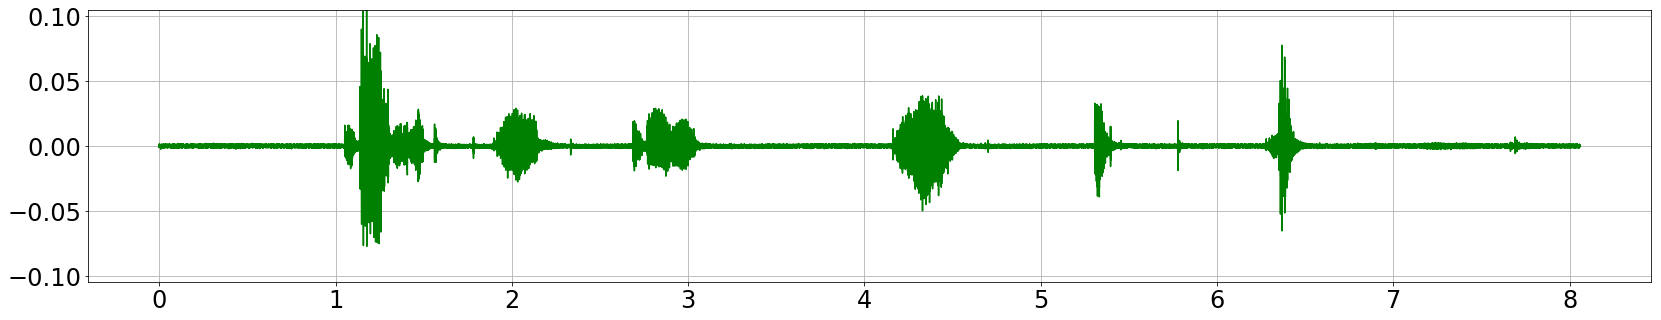

In [7]:
import soundfile as sf
import numpy as np

fs = 44100
# with sf.SoundFile('test.wav') as f:
    # data = f.read()

# with sf.SoundFile('short_sample.wav', 'w', fs, 1) as f:
    # f.write(data[int(fs*8.5): fs*10])

import matplotlib.pyplot as plt

with sf.SoundFile('test_speech.wav') as f:
    data_o = f.read()

plt.rcParams['figure.figsize'] = (28, 5)
plt.rcParams['font.size'] = 24
plt.grid(which='both')
plt.plot([i/fs for i in range(len(data_o))], data_o, 'g')
plt.ylim(-np.max(abs(data_o)), np.max(abs(data_o)))

plt.show()

sd.play(data_o, fs)

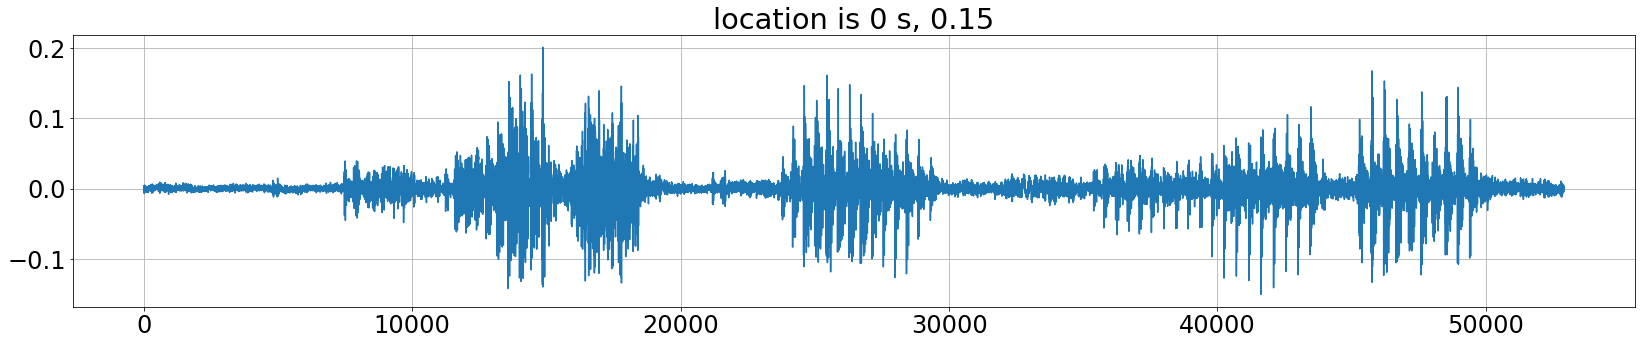

In [48]:
def plotter(data_in, win_count, win_time, noise_profile):
    data_section = data_in[int((win_count-1)*fs*win_time):int(win_count*fs*win_time)]
    mag, phase = my_fft(data_section)

    # freqs = [ff/len(mag)*fs for ff in range(len(mag))]

    # plt.plot(freqs, phase)
    # plt.grid(which='both')
    # plt.xlim(0, int(fs/4))
    # plt.show()

    # mag2, phase2 = my_fft(mag)
    # plt.plot(freqs, mag2)
    # plt.grid(which='both')
    # plt.xlim(0, int(fs/4))
    # plt.show()

    filtered_p = my_lowpass(phase)
    filtered = my_lowpass(mag)
    # plt.plot(freqs, filtered)
    # plt.xlim(0, int(fs/4))
    # plt.show()


    time_signal = [mm[0]*np.exp(1j*mm[1]) for mm in zip(filtered, phase)]
    res = np.real(fftpack.ifft(time_signal))
    ncorr = signal.correlate(res, noise_profile)
    
    time_axis = np.linspace(int((win_count-1)*fs*win_time), int(win_count*fs*win_time), len(res))
    # plt.plot(time_axis, res)
    plt.plot(time_axis, data_section)
    plt.grid(which='both')
    plt.title(f"location is {int((win_count-1)*win_time)} s, {np.sqrt(np.mean(np.square(ncorr)))/np.max(ncorr):.2f}")
    plt.show()

    sos = signal.butter(8, [100/fs, 20000/fs], 'band', output='sos')
    res = signal.sosfiltfilt(sos, res)
    
    return res

def doit(f, data_o):
    return [f(dd) for dd in data_o]

import sounddevice as sd

# data = doit(lambda a: a*10, data_o)
noise_profile = data_o[:int(0.02*fs)]

# plotter(data, 1)
# plotter(data, 2)
res = plotter(signal.wiener(data_o, 5), 1, 1.2, noise_profile)
# res = doit(lambda a: a*10, res)

# sd.play(data_o, samplerate=fs, blocking=True)
# sd.play(res, samplerate=fs, blocking=True)
# sd.play(signal.wiener(res, 5), samplerate=fs)




In [42]:

import numpy as np
from scipy import signal, fftpack


def my_fft(fft_data):
    Y = fftpack.fft(fft_data)
    phase = np.unwrap(np.angle(Y))
    # phase = np.angle(Y)
    magnitude = np.abs(Y)

    return magnitude, phase

def my_corr(in_data):
    corr = signal.correlate(data, data)
    lags = signal.correlation_lags(len(data), len(data))

    return lags, corr

def my_lowpass(data):
    sos = signal.butter(4, 0.2, 'low', output='sos')
    filtered = signal.sosfiltfilt(sos, data)
    
    return filtered


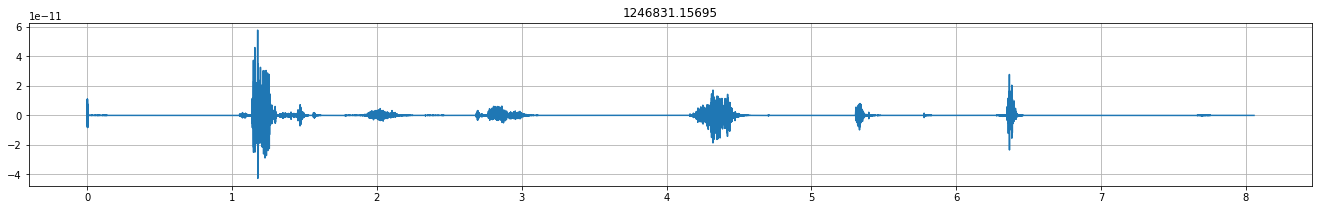

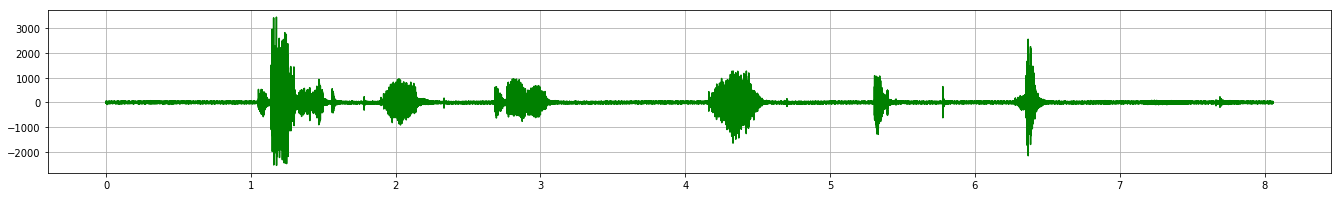

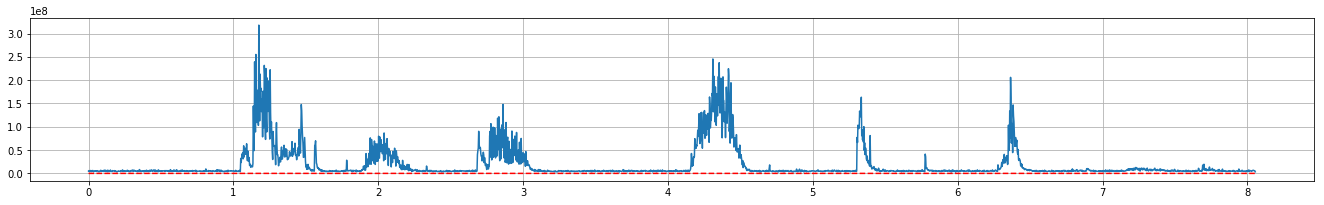

In [3]:
import PyOctaveBand
import soundfile as sf
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fftpack, special


def my_fft(fft_data):
    Y = fftpack.fft(fft_data)
    phase = np.unwrap(np.angle(Y))
    # phase = np.angle(Y)
    magnitude = np.abs(Y)

    return magnitude, phase

def my_corr(in_data):
    corr = signal.correlate(in_data, in_data)
    lags = signal.correlation_lags(len(in_data), len(in_data))

    return lags, corr

def my_lowpass(in_data):
    sos = signal.butter(16, 0.8, 'low', output='sos')
    filtered = signal.sosfiltfilt(sos, in_data)
    
    return filtered

def plotter(data_section, _pos, noise_profile):
    mag, phase = my_fft(data_section)

    filtered_p = my_lowpass(phase)
    filtered = my_lowpass(mag)

    time_signal = [mm[0]*np.exp(1j*mm[1]) for mm in zip(filtered, phase)]
    res = np.real(fftpack.ifft(time_signal))
    ncorr = signal.correlate(res, noise_profile)
    
    # time_axis = np.linspace(int((_pos)*_time_ms), int((_pos+1)*_time_ms), len(res))
    plt.plot(res)
    plt.plot(data_section)
    plt.grid(which='both')
    plt.title(f"location is {_pos/fs} s, {np.max(abs(ncorr))/np.sqrt(np.mean(np.square(noise_profile))):.2f}")
    plt.show()

    # sos = signal.butter(8, [100/fs, 16000/fs], 'band', output='sos')
    # res = signal.sosfiltfilt(sos, res)
    
    return res

fs = 44100
timewindow = 128/fs
# timewindow = 2048/fs
samples = int(fs*timewindow)

feature_1 = []
feature_2 = []
feature_3 = []
feature_4 = []

noise_std = 0.3
# noise_profile1 = data_o[:samples]
# noise_profile1 = np.random.rayleigh(scale=0.6, size=samples)*noise_std
noise_profile2 = np.random.randn(samples)*noise_std
# noise_profile3 = np.random.randn(samples)*noise_std

# noise_profile1 = noise_profile1/np.max(abs(noise_profile1))*2**15
noise_profile2 = noise_profile2/np.max(abs(noise_profile2))*2**15
# noise_profile3 = noise_profile3/np.max(abs(noise_profile3))*2**15

# sos = signal.butter(16, 80/44100, 'high', output='sos')
# noise_profile1 = signal.sosfiltfilt(sos, noise_profile1)
# noise_profile2 = signal.sosfiltfilt(sos, noise_profile2)
# noise_profile3 = signal.sosfiltfilt(sos, noise_profile3)

# print(len(noise_profile2))
# # count = 8
# for i in range(0, len(noise_profile2), 10):
#     print(f"{int(noise_profile2[i]*pow(2,15)):6},", 
#           f"{int(noise_profile2[i+1]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+2]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+3]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+4]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+5]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+6]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+7]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+8]*pow(2,15)):6},",
#           f"{int(noise_profile2[i+9]*pow(2,15)):6},")
# plt.plot(noise_profile1*pow(2,15))
# plt.plot(noise_profile2*pow(2,15))
# plt.plot(noise_profile3*pow(2,15))

highest_gain = 2**30
previous_gain = 1
alpha = 0.8

final_signal = np.ones(0)

# splb, freqb, n1xb = PyOctaveBand.octavefilter(noise_profile1, fs=fs, fraction=1, order=4, limits=[12, 20000], show=0, sigbands=1)
# splb, freqb, n2xb = PyOctaveBand.octavefilter(noise_profile2, fs=fs, fraction=1, order=4, limits=[12, 20000], show=0, sigbands=1)
# splb, freqb, n3xb = PyOctaveBand.octavefilter(noise_profile3, fs=fs, fraction=1, order=4, limits=[12, 20000], show=0, sigbands=1)


with sf.SoundFile('test_speech.wav') as f:
    data_o = f.read()*2**15


with sf.SoundFile('test_speech.wav') as f:
    while f.tell() < f.frames:
        pos = f.tell()
        data = f.read(samples)*2**15

        # mag, phase = my_fft(data)

        # filtered_p = my_lowpass(phase)
        # filtered = my_lowpass(mag)

        # time_signal = [mm[0]*np.exp(1j*mm[1]) for mm in zip(filtered, phase)]
        # res = np.real(fftpack.ifft(time_signal))
#############################################################
        # splb, freqb, xb = PyOctaveBand.octavefilter(data, fs=fs, fraction=1, order=4, limits=[12, 20000], show=0, sigbands=1)

        # gains = np.ones(len(xb))
        # for ii, xx in enumerate(xb):
        #     xb[ii] = xb[ii][:len(data)]
        #     ncorr1 = signal.correlate(xb[ii], n1xb[ii])
        #     ncorr2 = signal.correlate(xb[ii], n2xb[ii])
        #     ncorr3 = signal.correlate(xb[ii], n3xb[ii])
        #     gains[ii] = np.mean([np.max(abs(ncorr1)), np.max(abs(ncorr2)), np.max(abs(ncorr3))])
        #     gains[ii] = (1-alpha)*gains[ii]/highest_gain + alpha

        # result_block = np.dot(gains, xb)

        # final_signal = np.hstack([final_signal, result_block])
#############################################################
        # plt.plot(res)
        # plt.plot(data)
        # plt.plot(signal.wiener(data))
        # plt.grid(which='both')
        # plt.title(f"location is {pos/fs} s, {np.max(abs(ncorr))/np.sqrt(np.mean(np.square(noise_profile))):.2f}")
        # plt.show()

        # res = plotter(data, pos, noise_profile)

        # ncorr = signal.correlate(res, noise_profile)
        # feature_1.append(np.max(ncorr)/np.sqrt(np.mean(np.square(ncorr))))

#############################################################

        # ncorr1 = signal.correlate(data, noise_profile1)
        ncorr2 = signal.correlate(data, noise_profile2)
        # ncorr3 = signal.correlate(data, noise_profile3)

        # feature_1.append(np.max(ncorr1))
        feature_2.append(np.max(ncorr2))
        # feature_3.append(np.max(ncorr3))
        # gain = np.mean([np.max(abs(ncorr1)), np.max(abs(ncorr2)), np.max(abs(ncorr3))])

        gain = np.max(abs(ncorr2))/highest_gain
        # if gain > 1:
        #     highest_gain = gain
        gain = (1-alpha)*gain/highest_gain + alpha*previous_gain/highest_gain
        previous_gain = gain

        final_signal = np.hstack([final_signal, np.multiply(gain, data)])
        
        feature_4.append(gain)
#############################################################

        # plt.plot([f/len(corr_spect)*fs for f in range(len(corr_spect))], 
                #   20*np.log10(abs(corr_spect)))
        # plt.xlim(0, int(fs/4))
        # plt.grid(which='both')
        # plt.title(f"location is {pos/fs} s, {np.std(corr_spect):.2}")
        # plt.ylim(-150, 20)
        # plt.show()
        

    final_signal = [10*a/(2**15) for a in final_signal]

    plt.rcParams['figure.figsize'] = (23,3)
    plt.plot([i/fs for i in range(len(final_signal))], final_signal)
    plt.title(f"{ncorr2[int((len(ncorr2)-1)/2)]:.5f}")
    plt.grid(which='both')
    plt.show()

    plt.grid(which='both')
    plt.plot([i/fs for i in range(len(data_o))], data_o, 'g')
    # plt.ylim(-1, 1)
    plt.show()

    # plt.plot([i/fs*samples for i in range(len(feature_1))], feature_1)
    plt.plot([i/fs*samples for i in range(len(feature_2))], feature_2)
    # plt.plot([i/fs*samples for i in range(len(feature_1))], feature_3)
    plt.plot([i/fs*samples for i in range(len(feature_2))], np.multiply(feature_4, 1), '--r')
    plt.grid(which='both')
    # plt.legend(['noise profile 1', 'noise profile 2', 'noise profile 3', 'gain'])
    plt.show()
    

    # sos = signal.butter(16, (50/44100, 20000/44100), 'band', output='sos')
    # final_signal = signal.sosfiltfilt(sos, final_signal)

    # plt.plot(filtered)
    # plt.grid(which='both')
    # plt.ylim(-2, 5)
    # plt.show()


    # plt.plot(lags, 20*np.log10(abs(corr2)))
    # plt.grid(which='both')
    # plt.title(f"location is {pos/fs} s, {np.sum(corr2)/np.max(corr2):.2f}")
    # # plt.ylim(-0.5, 0.5)
    # plt.show()

    # sd.play(data_o, samplerate=fs, blocking=True)
    sd.play(final_signal, samplerate=fs, blocking=True)

    # sf.write('feature_1.wav', final_signal, samplerate=fs)

[ 9 23]
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
247268


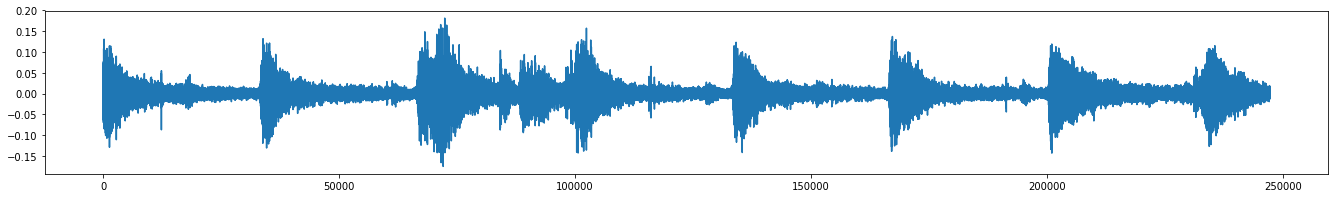

In [23]:
import sounddevice as sd


print(np.dot([2, 3], [[3, 4], [1, 5]]))
splb, freqb, xb = PyOctaveBand.octavefilter(data_o, fs=44100, fraction=1, order=4, limits=[12, 20000], show=0, sigbands=1)

print(len(data_o))
for i in range(len(xb)):
    xb[i] = xb[i][:len(data_o)]
#     plt.plot(i)
#     plt.show()

gains = []
plt.plot(np.dot(np.ones(len(xb)), xb))
# plt.plot(xb[9][:len(data_o)])

# sd.play(xb[6], samplerate=fs, blocking=True)


In [85]:
import sounddevice as sd
import time
from scipy import signal
import numpy as np
import queue

samples = 512
print(samples/44100)
# noise_profile1 = np.random.rayleigh(scale=0.6, size=samples)*0.5
noise_profile2 = np.random.randn(samples)
# noise_profile3 = np.random.randn(samples)*0.5

noise_profile2 = noise_profile2/np.max(noise_profile2)

sos = signal.butter(16, (20/44100, 3000/44100), 'band', output='sos')
noise_profile2 = signal.sosfilt(sos, noise_profile2)

normalize_value = 1 # highest possible correlation value expected
alpha = 0.05 # amount of dry signal
# previous_gain = [1]

# q = []
def callback(indata, outdata, frames, time, status):

    # ncorr1 = signal.correlate(indata[:, 1], noise_profile1[:])
    ncorr2 = signal.correlate(indata[:, 1], noise_profile2[:])
    # ncorr3 = signal.correlate(indata[:, 1], noise_profile3[:])

    # gain = np.mean([np.max(abs(ncorr1)), np.max(abs(ncorr2)), np.max(abs(ncorr3))])
    gain = np.max(abs(ncorr2))
    gain = (1-alpha)*gain/normalize_value + alpha*previous_gain[0]/normalize_value
    # previous_gain[0] = gain

    # [q.append(ii) for ii in indata[:, 1]]
    outdata[:] = np.multiply(indata[:], gain*2)

previous_gain = [1]
str = sd.Stream(device=(1, 5), samplerate=44100, blocksize=samples, channels=2, callback=callback)
str.start()
time.sleep(10)
str.close()

# import matplotlib.pyplot as plt
# plt.plot(q)

# plot_buffer = []
# while not q.empty():
#     plot_buffer.append(q.get())
# plt.plot(plot_buffer)
# plt.show()


0.011609977324263039


In [17]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Digitale Audioschnittstelle (Te, MME (2 in, 0 out)
   2 CABLE Output (VB-Audio Virtual , MME (2 in, 0 out)
   3 Microphone Array (Conexant Smar, MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  5 Speakers (Conexant SmartAudio H, MME (0 in, 2 out)
   6 Digitale Audioschnittstelle (Te, MME (0 in, 2 out)
   7 CABLE Input (VB-Audio Virtual C, MME (0 in, 2 out)
   8 S24E650 (Intel(R) Display-Audio, MME (0 in, 2 out)
   9 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
  10 Digitale Audioschnittstelle (Teensy Audio), Windows DirectSound (2 in, 0 out)
  11 CABLE Output (VB-Audio Virtual Cable), Windows DirectSound (2 in, 0 out)
  12 Microphone Array (Conexant SmartAudio HD), Windows DirectSound (2 in, 0 out)
  13 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  14 Speakers (Conexant SmartAudio HD), Windows DirectSound (0 in, 2 out)
  15 Digitale Audioschnittstelle (Teensy Audio), W